In [1]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
import model.agents as agents
from model.stochastic_processes import (
    create_stochastic_avail_price_process,
    plot_price,
)
from model.agents_class import Stake

In [4]:
import os
import sys
print("Current Working Directory:", os.getcwd())
print("Python Path:", sys.path)


Current Working Directory: /Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon
Python Path: ['/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages']


In [5]:
# types
Run = int
Timestep = int

# Price Traj Generation

<class 'float'>


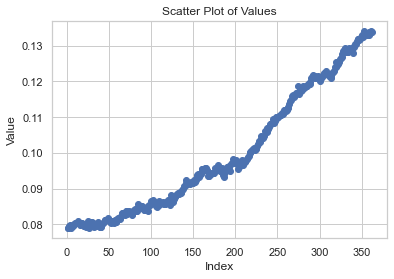

0.07887329326752537


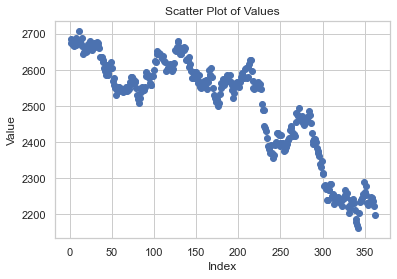

2160.900428270494


In [6]:
avl_price_samples = create_stochastic_avail_price_process(price_traj_type = 'convex',minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0,)
plot_price(avl_price_samples) 
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave', minimum_avl_price=1500,target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [7]:
constants = {
}

# Simulation

In [8]:
const_multiplier = 1e3
AVL_initial_weights = 0.7
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.07887329326752537


In [9]:
init_agent_eth_alloc = [0.75, 0.43, 1.0]
init_agent_avl_alloc = [1-i for i in init_agent_eth_alloc]
agents_composition = [0.695,0.305,0.0] # sum = 1

In [10]:
init_AVL_price = AVL_initial_price
init_fdv = 10000000000 * init_AVL_price
init_inflation_rate = 4
init_rewards_allocation = 20
init_target_avg_yield = 5
init_total_inflation_rewards = init_fdv * init_inflation_rate /100
init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100


init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield

print(init_target_total_security)

126197269.2280406


In [11]:
init_AVL_security_pct = [ i*j for i,j in zip(init_agent_avl_alloc, agents_composition)]
init_ETH_security_pct = [ i*j for i,j in zip(init_agent_eth_alloc, agents_composition)]

print(init_AVL_security_pct, init_ETH_security_pct)

init_total_AVL_security_pct = sum(init_AVL_security_pct)
init_total_ETH_security_pct = sum(init_ETH_security_pct)

print([i/init_total_AVL_security_pct for i in init_AVL_security_pct])
print([i/init_total_ETH_security_pct for i in init_ETH_security_pct])

agents_avl_balance = [init_target_total_security * pct / AVL_initial_price for pct in init_AVL_security_pct]
agents_eth_balance = [init_target_total_security * pct / ETH_initial_price for pct in init_ETH_security_pct]

print(agents_avl_balance)
print(agents_eth_balance)

[0.17375, 0.17385, 0.0] [0.52125, 0.13115, 0.0]
[0.49985615650172605, 0.5001438434982739, 0.0]
[0.7989730226854691, 0.20102697731453095, 0.0]
[np.float64(278000000.0), np.float64(278160000.0), np.float64(0.0)]
[np.float64(24582.34814496886), np.float64(6185.083854604635), np.float64(0.0)]


In [12]:
df = pd.DataFrame({
    'Agent ETH Allocation %': init_agent_eth_alloc,
    'Agent AVL Allocation %': init_agent_avl_alloc
})
df['Agent ETH Allocation %'] = df['Agent ETH Allocation %'].apply(lambda x: f"{x:.2%}")
df['Agent AVL Allocation %'] = df['Agent AVL Allocation %'].apply(lambda x: f"{x:.2%}")
print(df)


avl_normalized = [i / sum(init_AVL_security_pct) for i in init_AVL_security_pct]
eth_normalized = [i / sum(init_ETH_security_pct) for i in init_ETH_security_pct]

df = pd.DataFrame({
    'AVL Security %': avl_normalized,
    'ETH Security %': eth_normalized
})
df['AVL Security %'] = df['AVL Security %'].apply(lambda x: f"{x:.2%}")
df['ETH Security %'] = df['ETH Security %'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'User Total Proportion': agents_composition
})
df['User Total Proportion'] = df['User Total Proportion'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'Total Security %': [init_total_AVL_security_pct*100, init_total_ETH_security_pct*100]
}, index=['AVL', 'ETH'])
df['Total Security %'] = df['Total Security %'].apply(lambda x: f"{x:.0f}%")
print(df)

  Agent ETH Allocation % Agent AVL Allocation %
0                 75.00%                 25.00%
1                 43.00%                 57.00%
2                100.00%                  0.00%
  AVL Security % ETH Security %
0         49.99%         79.90%
1         50.01%         20.10%
2          0.00%          0.00%
  User Total Proportion
0                69.50%
1                30.50%
2                 0.00%
    Total Security %
AVL              35%
ETH              65%


In [13]:
@dataclass
class FusionParams:
    # TODO: Set a AVL amount budget cap
    AVL_upper_budget_cap = 1.12e8
    ETH_upper_budget_cap = 2.08e8

    AVL_initial_weights: List[float] = default([AVL_initial_weights])

    avl_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: avl_price_samples[timestep]]
    )
    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    # inlation % on AVL
    inflation_rate: List[float] = default([init_inflation_rate])

    # % of Rewards Allocated to Fusion
    rewards_allocation: List[float] = default([init_rewards_allocation])


    # Reward Allocation to Pools
    ETH_reward_pct: List[float] = default([40])
    AVL_reward_pct: List[float] = default([60])


    # % of Fusion Security Standard met by ETH Stake
    # TODO: implementation
    ETH_upper_security_pct: List[float] = default([35])
    AVL_upper_security_pct: List[float] = default([65])



    # Agents
    ETH_agent_allocation: List[List[float]] = default([
        init_agent_eth_alloc
    ])
    AVL_agent_allocation: List[List[float]] = default([
        init_agent_avl_alloc
    ])
    Agents_composition: List[List[float]] = default([
        agents_composition
    ])

    agents_avl_balance: List[List[float]] = default([
        agents_avl_balance
    ])

    agents_eth_balance: List[List[float]] = default([
        agents_eth_balance
    ])

parameters = FusionParams().__dict__

In [14]:
psub = [
    {
        "policies": {
             },
        "variables": {
            "timestep": basic_model.update_timestep,
            "avl_price": basic_model.update_avl_price,
            "eth_price": basic_model.update_eth_price,
        }
    },
    {
        "policies": {
            "action":basic_model.calc_rewards
             },
        "variables": {
            "total_annual_rewards": basic_model.update_total_annual_rewards,
            "total_annual_rewards_fusion": basic_model.update_total_annual_rewards_fusion,
            "total_fdv": basic_model.update_total_fdv,
        }
    }, 
    {
        "policies": {
            "action": basic_model.calc_security_shares
            },
            "variables": {
                "AVL_security_pct": basic_model.update_AVL_pct,
                "ETH_security_pct": basic_model.update_ETH_pct,
                "total_security": basic_model.update_total_security,
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_rewards_allocation
            },
            "variables": {
                "AVL_stake": agents.update_AVL_stake,
                "ETH_stake": agents.update_ETH_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_yields
            },
            "variables": {
                "yield_pcts": agents.update_yields,
                "avg_yield": agents.update_avg_yield,
            }
    },
]

initial_conditions = {
    "timestep": 0,
    "avl_price": AVL_initial_price,
    "eth_price": ETH_initial_price, 
    "AVL_security_pct": sum(init_AVL_security_pct) * 100,
    "ETH_security_pct": sum(init_ETH_security_pct) * 100,
    "total_security": init_target_total_security,
    # "target_total_security": init_target_total_security,
    "total_fdv": init_fdv,
    "total_annual_rewards": init_total_inflation_rewards,
    "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
    "avg_yield": 5.0,
    "ETH_stake": Stake(ETH_initial_price, agents_eth_balance,0,0),
    "AVL_stake": Stake(AVL_initial_price, agents_avl_balance,0,0),
    "yield_pcts": [0,0,0],
    "avg_yield": 0.0,
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [15]:
simulation = Simulation(model=model, timesteps=300, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

43866170.78366691
82331098.44437368
44000018.97274512
82691826.03411524
44318317.66937192
82274623.8273961
44446804.81194613
82163623.72507063
43943425.711191446
82093164.34925348
44294876.71776965
82537096.90260985
44468975.81287284
82767206.66486073
44262828.08347852
82135296.81400216
44489566.04082638
82252878.19880006
44632762.088171855
82499154.05520254
44748951.59772613
83361696.8945215
44762575.06667167
82525296.00128971
44977000.23135058
82199751.27174392
44695156.322471514
82709859.13626654
44635494.30777205
82018996.46517771
44452564.87110614
81397907.18522131
44688163.095028624
81544028.18183872
44707659.33214201
81914391.46988864
44598869.62567965
81531196.14022346
44300937.536239974
81688351.1349056
44206293.46875182
81656675.44740063
44214570.115478665
82251577.75857453
44113302.17731814
82167458.65785146
44619663.92253337
82526713.8895193
45015090.231296346
82040244.791628
43972137.17622889
81874936.17645873
44653812.73186661
81749270.33381604
44728066.82036741
82176020.

/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon/model/agents.py:46: RuntimeWarning: invalid value encountered in scalar divide
  total_yield_pct = total_rewards / total_balance * 100


In [16]:
df

,timestep,avl_price,eth_price,AVL_security_pct,ETH_security_pct,total_security,total_fdv,total_annual_rewards,total_annual_rewards_fusion,avg_yield,ETH_stake,AVL_stake,yield_pcts,simulation,subset,run,substep
0,0,0.078873,2675.917134,34.760000,65.240000,1.261973e+08,7.887329e+08,3.154932e+07,6.309863e+06,0.000000,Stake(initial_price=np.float64(2675.9171335948...,Stake(initial_price=np.float64(0.0788732932675...,"[0, 0, 0]",0,0,1,0
1,1,0.078873,2675.917134,34.760000,65.240000,1.261973e+08,7.887329e+08,3.154932e+07,6.309863e+06,0.000000,Stake(initial_price=np.float64(2675.9171335948...,Stake(initial_price=np.float64(0.0788732932675...,"[0, 0, 0]",0,0,1,1
2,1,0.078873,2675.917134,34.760000,65.240000,1.261973e+08,7.887329e+08,3.154932e+07,6.309863e+06,0.000000,Stake(initial_price=np.float64(2675.9171335948...,Stake(initial_price=np.float64(0.0788732932675...,"[0, 0, 0]",0,0,1,2
3,1,0.078873,2675.917134,34.760000,65.240000,1.261973e+08,7.887329e+08,3.154932e+07,6.309863e+06,0.000000,Stake(initial_price=np.float64(2675.9171335948...,Stake(initial_price=np.float64(0.0788732932675...,"[0, 0, 0]",0,0,1,3
4,1,0.078873,2675.917134,34.760000,65.240000,1.261973e+08,7.887329e+08,3.154932e+07,6.309863e+06,0.000000,Stake(initial_price=np.float64(2675.9171335948...,Stake(initial_price=np.float64(0.0788732932675...,"[0, 0, 0]",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,300,0.120206,2314.840262,48.303619,51.696381,1.396784e+08,1.213135e+09,4.852541e+07,9.705081e+06,6.948161,Stake(initial_price=np.float64(2346.9194075855...,Stake(initial_price=np.float64(0.1213135184565...,"[6.576745895995615, 7.6517198623862335, nan]",0,0,1,1
1497,300,0.120206,2314.840262,48.303619,51.696381,1.396784e+08,1.202060e+09,4.808241e+07,9.616482e+06,6.948161,Stake(initial_price=np.float64(2346.9194075855...,Stake(initial_price=np.float64(0.1213135184565...,"[6.576745895995615, 7.6517198623862335, nan]",0,0,1,2
1498,300,0.120206,2314.840262,48.418289,51.581711,1.380755e+08,1.202060e+09,4.808241e+07,9.616482e+06,6.948161,Stake(initial_price=np.float64(2314.8402621304...,Stake(initial_price=np.float64(0.1202060215533...,"[6.576745895995615, 7.6517198623862335, nan]",0,0,1,3
1499,300,0.120206,2314.840262,48.418289,51.581711,1.380755e+08,1.202060e+09,4.808241e+07,9.616482e+06,6.948161,Stake(initial_price=np.float64(2314.8402621304...,Stake(initial_price=np.float64(0.1202060215533...,"[6.576745895995615, 7.6517198623862335, nan]",0,0,1,4


In [17]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "downside",
}
)

In [18]:
visualizations.plot_security_pct(
    df
)

In [19]:
visualizations.plot_avg_overall_yield(
    df
)

In [20]:
visualizations.plot_yield_pct(
    df, init_agent_eth_alloc
)